<a href="https://colab.research.google.com/github/tommymmcguire/DeerAI-540/blob/main/Untrained_ResNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Remove Colab default sample_data
!rm -r ./sample_data

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import time
import copy
import numpy as np
from tqdm import tqdm
import os
import shutil
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models
import torch.nn as nn
from collections import Counter
import re

In [4]:
import re
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class AgeDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        # Ensure only image files are listed
        self.filenames = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_name).convert('RGB')
        basename = os.path.basename(img_name)

        # Extract the age using regex to find the last sequence of digits
        matches = re.findall(r'\d+', basename)
        if not matches:
            raise ValueError(f"No age found in filename: {img_name}")
        # The age is the last sequence of digits
        age_str = matches[-1]
        age = float(age_str)

        if self.transform:
            image = self.transform(image)

        return image, age

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming the paths to your dataset directories are correctly set
train_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/train', transform=transform)
val_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/val', transform=transform)
test_dataset = AgeDataset('./drive/MyDrive/CKWRI Deer Photos/datasets/test', transform=transform)

num_workers = 4  # or 8 as a test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
from torchvision import models
import torch.nn as nn

# Initialize an untrained ResNet model
model = models.resnet50(pretrained=False)

# Modify the final fully connected layer to output a single value for age
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [7]:
import torch
from tqdm import tqdm

# Ensure the model is in evaluation mode
model.eval()

predictions = []

# No need to track gradients for inference
with torch.no_grad():
    for images, _ in tqdm(test_loader, desc="Predicting"):
        images = images.to(device)

        # Forward pass to get outputs
        outputs = model(images)

        # You might want to apply any necessary post-processing on outputs here

        predictions.extend(outputs.cpu().numpy())

# predictions now contains the age predictions from the untrained model

Predicting:   0%|          | 0/68 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Predicting:  99%|█████████▊| 67/68 [02:59<00:00,  1.05it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Predicting: 100%|██████████| 68/68 [02:59<00:00,  2.65s/it]


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

actual_ages = []
predicted_ages = []
losses = []

criterion = nn.MSELoss()

with torch.no_grad():
    for images, ages in tqdm(test_loader, desc="Evaluating"):
        images, ages = images.to(device), ages.to(device)
        actual_ages.extend(ages.cpu().numpy())

        outputs = model(images).squeeze()  # Ensure output shape matches the target
        predicted_ages.extend(outputs.cpu().numpy())

        loss = criterion(outputs, ages.float()).item()
        losses.append(loss)

# Convert lists to numpy arrays for calculation
actual_ages = np.array(actual_ages)
predicted_ages = np.array(predicted_ages)

# Calculate MAE and RMSE
mae = mean_absolute_error(actual_ages, predicted_ages)
rmse = sqrt(mean_squared_error(actual_ages, predicted_ages))

# Calculate average loss
avg_loss = np.mean(losses)

print(f'Average Loss: {avg_loss:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


Evaluating: 100%|██████████| 68/68 [01:56<00:00,  1.71s/it]

Average Loss: 543.7687
Mean Absolute Error (MAE): 22.6058
Root Mean Squared Error (RMSE): 23.3204


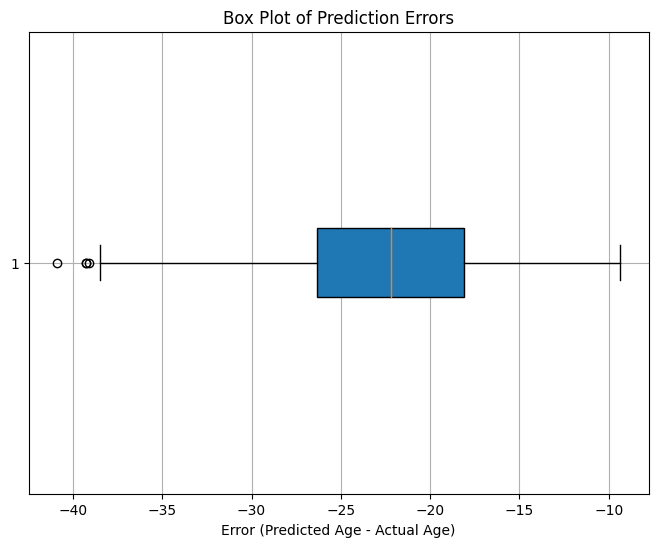

In [9]:
errors = predicted_ages - actual_ages

plt.figure(figsize=(8, 6))
plt.boxplot(errors, vert=False, patch_artist=True)
plt.xlabel('Error (Predicted Age - Actual Age)')
plt.title('Box Plot of Prediction Errors')
plt.grid(True)
plt.show()
